In [1]:
# 1_Baseline_Training.ipynb
# Train and test a simple CNN on MNIST

import os, time, json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import layers, models # type: ignore
import seaborn as sns

# Make folders to save results
BASE_DIR = "secure_ai_mnist"
os.makedirs(f"{BASE_DIR}/figures", exist_ok=True)
os.makedirs(f"{BASE_DIR}/models", exist_ok=True)

In [2]:
# Load MNIST dataset (automatically downloads if not present)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize and reshape
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)
x_test  = np.expand_dims(x_test, -1)

print("Training samples:", x_train.shape[0])
print("Testing samples:", x_test.shape[0])


Training samples: 60000
Testing samples: 10000


In [3]:
def build_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
        layers.MaxPooling2D(),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_cnn()
model.summary()


/Users/kartekeyaan/Chonky_folder/MNISTass/mnist-secure-ai-env/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-11-24 10:50:25.960585: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-11-24 10:50:25.960607: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-11-24 10:50:25.960612: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-11-24 10:50:25.960624: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-24 10:50:25.960632: I tensorflow/core/common_runtime/pluggable

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# ===================== STRIDE Vulnerabilities (Demo Only) =====================
# These are intentionally insecure patterns to illustrate STRIDE and to let Bandit flag issues.
# Do NOT use in production.

import os, tempfile

ENABLE_VULN_DEMOS = True
if ENABLE_VULN_DEMOS:
    # --- S (Spoofing) --------------------------------------------------------
    # Load model weights from an unverified location (no integrity check).
    # This simulates "trusting user-controlled paths" without prompting the user.
    # If the file exists, it will be loaded; otherwise it silently skips.
    UNVERIFIED_WEIGHTS_PATH = os.getenv(
        "UNVERIFIED_WEIGHTS_PATH",
        os.path.join(BASE_DIR, "models", "baseline_cnn.h5")  # default to a local file if present
    )
    try:
        if os.path.exists(UNVERIFIED_WEIGHTS_PATH):
            model.load_weights(UNVERIFIED_WEIGHTS_PATH)  # Unverified input path
    except Exception:
        # --- R (Repudiation) pattern: broad except hides what happened
        # Bandit: B110
        pass

    # --- T (Tampering) -------------------------------------------------------
    # Save model to a predictable, world-writable path (/tmp) without checks.
    # Bandit will flag related tmp usage elsewhere; tampering risk is conceptual here.
    INSECURE_SAVE_PATH = "/tmp/baseline_cnn.h5"
    try:
        model.save(INSECURE_SAVE_PATH)
    except Exception:
        pass  # (repudiation-like: swallow exceptions)

    # --- I (Information Disclosure) ------------------------------------------
    # Leak internal parameters: print a small slice of the first layer weights.
    # Shows how model internals could be exposed via logs.
    try:
        w = model.layers[0].get_weights()[0]
        print("🔓 Partial weights leak (shape", w.shape, "):\n", w[:2, :2, :1, :2])
    except Exception:
        pass

    # --- E (Elevation of Privilege) ------------------------------------------
    # Unsafe config loading: write a "config file" and eval() it back.
    # This simulates reading untrusted config and executing it.
    # Bandit: B307 (eval); plus mktemp below (B108).
    cfg_path = tempfile.mktemp(suffix=".cfg")   # Bandit: B108 (unsafe temp file usage)
    with open(cfg_path, "w") as f:
        # In a real attack this content could be attacker-controlled.
        f.write("{'epochs': 8, 'batch_size': 128}")

    with open(cfg_path) as f:
        cfg = eval(f.read())  # DANGEROUS: executing untrusted text (Bandit B307)

    # Use the (unsafe) config values to drive training params
    EPOCHS = int(cfg.get("epochs", 6))
    BATCH_SIZE = int(cfg.get("batch_size", 128))

    # Bonus: a hardcoded secret to trigger B105 (helps your SAST write-up)
    API_KEY = "AKIA-EXAMPLE-12345-SECRET"  # Bandit B105
else:
    EPOCHS, BATCH_SIZE = 8, 128
# ============================================================================

# ↓ Use the (possibly unsafe) EPOCHS/BATCH_SIZE in training

🔓 Partial weights leak (shape (3, 3, 1, 32) ):
 [[[[ 1.5455599  -1.7720697 ]]

  [[ 1.6392993   0.68737453]]]


 [[[ 1.7697517  -0.21375476]]

  [[ 2.2183905   1.6068925 ]]]]


In [5]:
start = time.time()
history = model.fit(
    x_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    verbose=2
)

train_time = time.time() - start

model.save(f"{BASE_DIR}/models/baseline_cnn.h5")
print(f"Training completed in {train_time:.1f} sec")

Epoch 1/8


2025-11-24 10:50:26.320683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


422/422 - 5s - 12ms/step - accuracy: 0.9710 - loss: 7.7859 - val_accuracy: 0.9810 - val_loss: 6.0233
Epoch 2/8
422/422 - 4s - 10ms/step - accuracy: 0.9707 - loss: 8.5978 - val_accuracy: 0.9850 - val_loss: 5.8568
Epoch 3/8
422/422 - 4s - 10ms/step - accuracy: 0.9704 - loss: 9.5697 - val_accuracy: 0.9840 - val_loss: 6.3674
Epoch 4/8
422/422 - 4s - 10ms/step - accuracy: 0.9693 - loss: 10.7709 - val_accuracy: 0.9813 - val_loss: 8.1101
Epoch 5/8
422/422 - 4s - 10ms/step - accuracy: 0.9687 - loss: 12.3088 - val_accuracy: 0.9875 - val_loss: 7.0161
Epoch 6/8
422/422 - 4s - 10ms/step - accuracy: 0.9711 - loss: 12.9118 - val_accuracy: 0.9873 - val_loss: 7.5718
Epoch 7/8
422/422 - 4s - 10ms/step - accuracy: 0.9705 - loss: 13.9472 - val_accuracy: 0.9848 - val_loss: 9.1439
Epoch 8/8
422/422 - 4s - 10ms/step - accuracy: 0.9696 - loss: 16.9324 - val_accuracy: 0.9867 - val_loss: 9.8713


Training completed in 34.6 sec


In [6]:
import time

# Evaluate model performance
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

# Measure inference time per image
num_samples = 2000
t0 = time.time()
_ = model.predict(x_test[:num_samples], batch_size=128, verbose=0)
t1 = time.time()
inf_time_per_image = (t1 - t0) / num_samples

print(f"✅ Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Average Inference Time per Image: {inf_time_per_image*1000:.3f} ms")


✅ Test Accuracy: 0.9858
Test Loss: 7.4402
Average Inference Time per Image: 0.062 ms


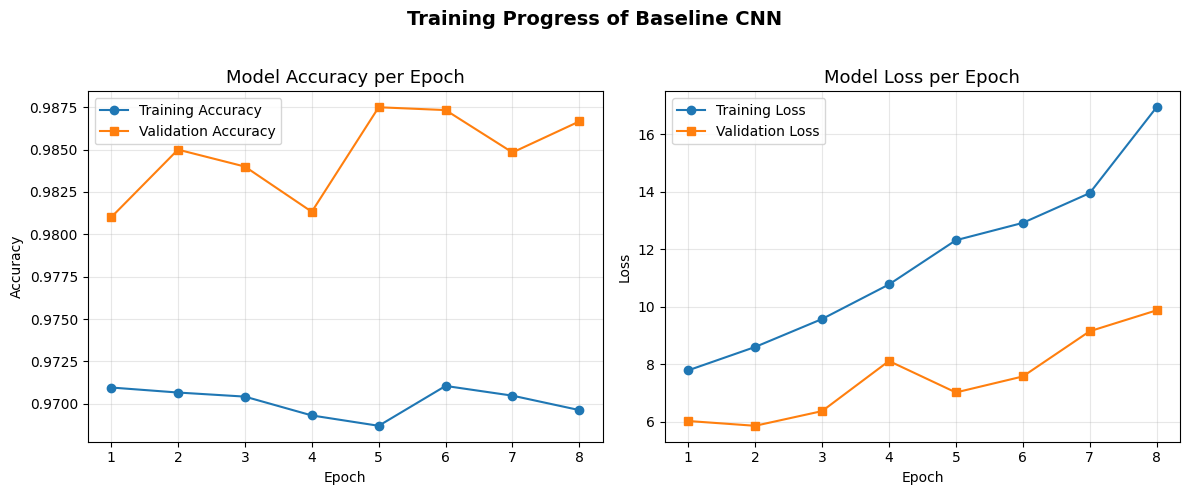

In [7]:
# --- Training and Validation Curves ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
epochs = range(1, len(history.history['accuracy']) + 1)

# Accuracy
axes[0].plot(epochs, history.history['accuracy'], marker='o', label='Training Accuracy')
axes[0].plot(epochs, history.history['val_accuracy'], marker='s', label='Validation Accuracy')
axes[0].set_title('Model Accuracy per Epoch', fontsize=13)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].grid(alpha=0.3)
axes[0].legend()

# Loss
axes[1].plot(epochs, history.history['loss'], marker='o', label='Training Loss')
axes[1].plot(epochs, history.history['val_loss'], marker='s', label='Validation Loss')
axes[1].set_title('Model Loss per Epoch', fontsize=13)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].grid(alpha=0.3)
axes[1].legend()

plt.suptitle('Training Progress of Baseline CNN', fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(f"{BASE_DIR}/figures/training_curves.png", bbox_inches="tight")
plt.show()


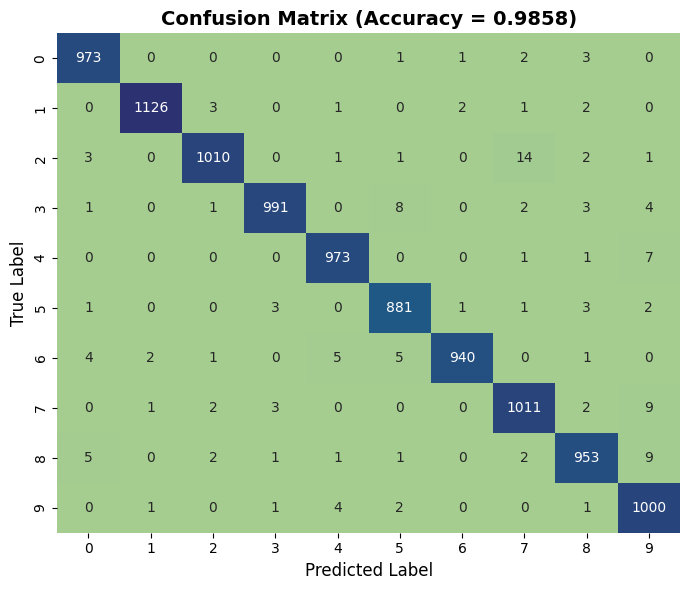

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion matrix
y_pred = np.argmax(model.predict(x_test, verbose=0), axis=1)
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='crest', cbar=False, ax=ax)
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title(f'Confusion Matrix (Accuracy = {test_acc:.4f})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{BASE_DIR}/figures/confusion_matrix.png", bbox_inches="tight")
plt.show()


In [9]:
import json

metrics = {
    "test_accuracy": float(test_acc),
    "test_loss": float(test_loss),
    "inference_time_per_image_sec": float(inf_time_per_image)
}

with open(f"{BASE_DIR}/baseline_metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("📊 Metrics saved successfully!")
print(json.dumps(metrics, indent=2))


📊 Metrics saved successfully!
{
  "test_accuracy": 0.98580002784729,
  "test_loss": 7.440238952636719,
  "inference_time_per_image_sec": 6.154048442840577e-05
}


In [10]:
!pip install bandit

In [11]:
import os, json, ast

# Optional: set exactly which notebook to convert
# os.environ["NB_NAME"] = "1_Baseline_Training.ipynb"

cwd = os.getcwd()
nb_name = os.environ.get("NB_NAME", "").strip()

def pick_latest_ipynb(path):
    ips = [f for f in os.listdir(path) if f.endswith(".ipynb")]
    if not ips:
        raise FileNotFoundError("No .ipynb found here.")
    ips.sort(key=lambda f: os.path.getmtime(os.path.join(path, f)), reverse=True)
    return ips[0]

if not nb_name:
    nb_name = pick_latest_ipynb(cwd)

nb_path = os.path.join(cwd, nb_name)
base_noext = os.path.splitext(nb_name)[0]
py_bandit_name = f"{base_noext}_bandit.py"
py_bandit_path = os.path.join(cwd, py_bandit_name)

print(f"[info] Converting: {nb_path} -> {py_bandit_path}")

def is_magic_or_shell(line: str) -> bool:
    s = line.lstrip()
    return (
        s.startswith("!") or
        s.startswith("%") or
        s.startswith("%%") or
        s.startswith("get_ipython()") or
        s.startswith("get_ipython(")
    )

with open(nb_path, "r", encoding="utf-8") as f:
    nb = json.load(f)

lines_out = ["# -*- coding: utf-8 -*-", "# Generated for Bandit scan (cleaned from .ipynb magics)", ""]
magics_count = 0

for cell in nb.get("cells", []):
    if cell.get("cell_type") != "code":
        continue
    src = cell.get("source", [])
    if isinstance(src, str):
        src = src.splitlines(True)
    lines_out.append("# %%")  # cell separator (OK for Python)
    for raw in src:
        # Normalize line endings
        line = raw.rstrip("\n")
        if is_magic_or_shell(line):
            # comment-out magics/shell so file stays valid Python
            lines_out.append(f"# [removed-magic] {line}")
            magics_count += 1
        else:
            lines_out.append(line)
    lines_out.append("")

script = "\n".join(lines_out) + "\n"

# Validate with AST; if it fails, print the error location for easy fixing
try:
    ast.parse(script)
    with open(py_bandit_path, "w", encoding="utf-8") as f:
        f.write(script)
    print(f"[ok] Wrote cleaned Python to: {py_bandit_path}")
    print(f"[ok] Removed/commented {magics_count} magic/shell lines.")
except SyntaxError as e:
    print("[error] The cleaned script still has a syntax error.")
    print(f"        {e.__class__.__name__}: {e}")
    # Write it out anyway to allow you to open and check
    with open(py_bandit_path, "w", encoding="utf-8") as f:
        f.write(script)
    print(f"[warn] Wrote faulty script to: {py_bandit_path} (open and fix around the reported line).")


[info] Converting: /Users/kartekeyaan/Chonky_folder/MNISTass/secure_ai_mnist/code/1_Baseline_Training.ipynb -> /Users/kartekeyaan/Chonky_folder/MNISTass/secure_ai_mnist/code/1_Baseline_Training_bandit.py
[ok] Wrote cleaned Python to: /Users/kartekeyaan/Chonky_folder/MNISTass/secure_ai_mnist/code/1_Baseline_Training_bandit.py
[ok] Removed/commented 1 magic/shell lines.


In [12]:
import os, subprocess, shlex, datetime

cwd = os.getcwd()
nb_name = os.environ.get("NB_NAME", "").strip()
if not nb_name:
    # mirror Cell 1 selection logic
    ipynbs = [f for f in os.listdir(cwd) if f.endswith(".ipynb")]
    ipynbs.sort(key=lambda f: os.path.getmtime(os.path.join(cwd, f)), reverse=True)
    nb_name = ipynbs[0]

base_noext = os.path.splitext(nb_name)[0]
py_bandit = f"{base_noext}_bandit.py"
py_bandit_path = os.path.join(cwd, py_bandit)

reports_dir = os.path.join(cwd, "reports")
os.makedirs(reports_dir, exist_ok=True)
stamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
report_path = os.path.join(reports_dir, f"bandit_report_{base_noext}_{stamp}.txt")

cmd = ["bandit", "-r", py_bandit_path, "-f", "txt", "-o", report_path]
print("[info] Running:", " ".join(shlex.quote(c) for c in cmd))
res = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)

print(res.stdout.strip() if res.stdout else "[info] Bandit finished.")
print(f"\n[ok] Bandit report saved to: {report_path}")
print(f"[ok] Scanned file:          {py_bandit_path}")


[info] Running: bandit -r /Users/kartekeyaan/Chonky_folder/MNISTass/secure_ai_mnist/code/1_Baseline_Training_bandit.py -f txt -o /Users/kartekeyaan/Chonky_folder/MNISTass/secure_ai_mnist/code/reports/bandit_report_1_Baseline_Training_20251124_105103.txt
[main]	INFO	profile include tests: None
[main]	INFO	profile exclude tests: None
[main]	INFO	cli include tests: None
[main]	INFO	cli exclude tests: None
[main]	INFO	running on Python 3.9.6
[text]	INFO	Text output written to file: /Users/kartekeyaan/Chonky_folder/MNISTass/secure_ai_mnist/code/reports/bandit_report_1_Baseline_Training_20251124_105103.txt

[ok] Bandit report saved to: /Users/kartekeyaan/Chonky_folder/MNISTass/secure_ai_mnist/code/reports/bandit_report_1_Baseline_Training_20251124_105103.txt
[ok] Scanned file:          /Users/kartekeyaan/Chonky_folder/MNISTass/secure_ai_mnist/code/1_Baseline_Training_bandit.py
